<a href="https://colab.research.google.com/github/eldapere8/Albanian-Topic-Modeling/blob/main/Albanian_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Semi-Supervised Topic Modeling of Albanian Tweets

<h1><center>Semi-Supervised Topic Modeling of Albanian Tweets
 </center></h1>
    
<h2><center>    Elda Pere </center></h2>
<h4><center>W266: Natural Language Processing</center></h4>
<h4><center>University of California, Berkeley</center></h4>
<h4><center>eldapere@ischool.berkeley.edu</center></h4>


#### Abstract
A majority of NLP research in the social media domain has evolved with English and a few other common languages in mind. This prevents agents with academic, political or economic interest from reaping the benefits that social media can provide from cultures speaking lesser known languages, while also keeping the latter in the dark about new products and ideas. With a novel tweet dataset we collected using research on the Albanian language, this paper aims to detect the main topics mentioned by Albanian tweets in a semi-supervised setting. It will study the performance of topic models using word embeddings trained on Word2Vec and BERT, which are then clustered using the kMeans algorithm. They are compared to each other and a Latent Dirichlet Allocation (LDA) baseline model using descriptive analysis, intrinsic measures and extrinsic metrics where hashtags are considered a ground truth label.



<b>[Link to Paper](https://docs.google.com/document/d/1XK3KTbG3dYqVEPOyoy9eggYGcGexNI8fp3RauiV1yH4/edit?usp=sharing)</b>

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sentencepiece
!pip install transformers
!pip install sentence_transformers
!pip install tmtoolkit
!pip install pandas==1.3.5

In [ ]:
import json
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re
from ast import literal_eval
import re,string


import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns

import torch
from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer

from datetime import datetime

from collections import defaultdict

import sentencepiece

from transformers import BertTokenizer, TFBertModel, T5Tokenizer, TFT5ForConditionalGeneration
from sentence_transformers import SentenceTransformer
import pandas as pd


In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
tf.get_logger().setLevel("ERROR") 

## Data Preprocessing <a id="preprocess" />

In [ ]:
df_2015 = pd.read_csv('/content/drive/MyDrive/Projects/AlbanianTwitter/data_sources/2015tweets.csv')
df_2016 = pd.read_csv('/content/drive/MyDrive/Projects/AlbanianTwitter/data_sources/2016tweets.csv')
df_2017 = pd.read_csv('/content/drive/MyDrive/Projects/AlbanianTwitter/data_sources/2017tweets.csv')
df_2018 = pd.read_csv('/content/drive/MyDrive/Projects/AlbanianTwitter/data_sources/2018tweets.csv')

In [ ]:
df_2015.shape, df_2016.shape, df_2017.shape, df_2018.shape

((2705, 29), (45872, 29), (52793, 29), (125034, 29))

In [ ]:
df = pd.concat([df_2015, df_2016, df_2017, df_2018], axis=0)

In [ ]:
#https://github.com/arditdine/albanian-nlp/blob/master/stem/__init__.py

class AlbStem(object):

    chars = [
        ('a', ['Á','á','Å','Ä','ä','Α','α','Ά','Ὰ','Ἀ','Ἄ','Ἂ','Ἆ','Ἁ','Ἅ','Ἃ','Ἇ','Ᾱ','Ᾰ','ά','ὰ','ᾶ','ἀ','ἄ','ἂ','ἆ','ἁ','ἅ','ἃ','ἇ','ᾱ','ᾰ','ᾼ','ᾈ','ᾌ','ᾊ','ᾎ','ᾉ','ᾍ','ᾋ','ᾏ','ᾳ','ᾴ','ᾲ','ᾷ','ᾀ','ᾄ','ᾂ','ᾆ','ᾁ','ᾅ','ᾃ','ᾇ','å','À','à','Â','â','Æ','æ','А','а','Ъ','ъ','Ă','ă','Ь','ь','Я','я','Ą','ą','Ã','ã']),
        ('b', ['Β','β','Б','б']),
        ('c', ['ç','Ç','Č','č','Ξ','ξ','Ћ','ћ','Ć','ć','Ц','ц','Ч','ч']),
        ('d', ['Ď','ď','Δ','δ','Д','д','Ђ','ђ','Đ','đ','Џ','џ','D','d̂̂']),
        ('e', ['ë','Ë','É','é','Ě','ě','Ε','ε','Έ','Ὲ','Ἐ','Ἔ','Ἒ','Ἑ','Ἕ','Ἓ','έ','ὲ','ἐ','ἔ','ἒ','ἑ','ἕ','ἓ','È','è','Ê','ê','Е','е','Ё','ё','Є','є','Ѣ','ѣ','Э','э','Ė','ė','Ę','ę']),
        ('f', ['Φ','φ','Ф','ф']),
        ('g', ['Γ','γ','Г','г','Ґ','ґ','G','g','Ѓ','ѓ','Ǵ','ǵ','ǵ̀̀','Ğ','ğ']),
        ('h', ['Η','η','Ή','Ὴ','Ἠ','Ἤ','Ἢ','Ἦ','Ἡ','Ἥ','Ἣ','Ἧ','ή','ὴ','ῆ','ἠ','ἤ','ἢ','ἦ','ἡ','ἥ','ἣ','ἧ','ῌ','ᾘ','ᾜ','ᾚ','ᾞ','ᾙ','ᾝ','ᾛ','ᾟ','ῃ','ῄ','ῂ','ῇ','ᾐ','ᾔ','ᾒ','ᾖ','ᾑ','ᾕ','ᾓ','ᾗ']),
        ('i', ['Í','í','Ι','ι','Ί','Ὶ','Ἰ','Ἴ','Ἲ','Ἶ','Ἱ','Ἵ','Ἳ','Ἷ','Ϊ','Ῑ','Ῐ','ί','ὶ','ῖ','ἰ','ἴ','ἲ','ἶ','ἱ','ἵ','ἳ','ἷ','ϊ','ΐ','ῒ','ῗ','ῑ','ῐ','Î','î','Ï','ï','ì','Ì','И','и','I','Ī','i','ī','Ї','ї','İ','ı']),
        ('j', ['Й','й','Ĭ','ĭ','Ј','ј','J','ǰ̌']),
        ('k', ['Κ','κ','К','к','k','Ќ','ќ','Ḱ','ḱ','Х','х']),
        ('l', ['Λ','λ','Л','л','Љ','љ','L','l̂̂','Ł','ł','Ĺ','ĺ','Ľ','ľ']),
        ('m', ['Μ','μ','М','м']),
        ('n', ['Ň','ň','Ν','ν','ñ','Н','н','Њ','њ','N','n̂̂','Ń','ń']),
        ('o', ['Ó','ó','Ø','Ö','ö','Ο','ο','Ό','Ὸ','Ὀ','Ὄ','Ὂ','Ὁ','Ὅ','Ὃ','ό','ὸ','ὀ','ὄ','ὂ','ὁ','ὅ','ὃ','Ô','ô','Œ','œ','ő','Ő','ò','Ò','о','О','ø','Õ','õ']),
        ('p', ['Π','π','П','п']),
        ('q', ['Θ','θ']),
        ('r', ['Ř','ř','Ρ','ρ','Ῥ','ῤ','ῥ','Р','р','Ŕ','ŕ']),
        ('s', ['Š','š','Σ','σ','ς','С','с','Ш','ш','Щ','щ','Ŝ','ŝ','Ŝŝ','Ś','ś','Ș','ș','Ş','ş']),
        ('t', ['Ť','ť','Τ','τ','Т','т','Ț','ț','Ţ','ţ']),
        ('u', ['Ú','ú','Ů','ů','Ü','ü','Υ','υ','Ύ','Ὺ','Ὑ','Ὕ','Ὓ','Ὗ','Ϋ','Ῡ','Ῠ','ύ','ὺ','ῦ','ὐ','ὔ','ὒ','ὖ','ὑ','ὕ','ὓ','ὗ','ϋ','ΰ','ῢ','ῧ','ῡ','ῠ','Ù','ù','Û','û','ű','Ű','Ŭ','ŭ','Ю','ю']),
        ('v', ['В','в',]),
        ('w', ['Ω','ω','Ώ','Ὼ','Ὠ','Ὤ','Ὢ','Ὦ','Ὡ','Ὥ','Ὣ','Ὧ','ώ','ὼ','ῶ','ὠ','ὤ','ὢ','ὦ','ὡ','ὥ','ὣ','ὧ','ῼ','ᾨ','ᾬ','ᾪ','ᾮ','ᾩ','ᾭ','ᾫ','ᾯ','ῳ','ῴ','ῲ','ῷ','ᾠ','ᾤ','ᾢ','ᾦ','ᾡ','ᾥ','ᾣ','ᾧ']),
        ('x', ['Χ','χ']),
        ('y', ['Ý','ý','Ψ','ψ','Ÿ','ÿ','У','у','Ў','ў','Ы','ы']),
        ('z', ['Ž','ž','Ζ','ζ','Ж','ж','Ẑ','ẑ','Ź','ź','Ż','ż','з']),
        ('ae', ['Æ','æ']),
        ('ss', ['ß']),
        (' ', ["\r","\n","\t",'"','\\',"’","'",'~','!','@','#','$','%','^','&','*','(',')','_','+','-','=','¨','«','»','`','[',']','{','}','|',':','<','>','?',',','/','.','¡','¢','£','¤','¥','¦','§','¨','©','ª','¬','­','®','¯','°','±','²','³','´','µ','¶','·','¸','¹','º','»','¼','½','¾','¿','₤','₠','₡','₢','₣','₧','⅓','⅔','⅛','⅜','⅝','⅞','⅞'])
    ]

    suffixes_strip = ['tarine', 'tarise', 'tari', 'shme', 'isht', 'shem', 'iste', 'mjet', 'sore', 'tare', 'uar', 'ore', 'eve', 'ave', 'esi', 'are', 'ike', 'ake', 'jes', 'ste', 'nte', 'ist', 'yer', 'et', 'ur', 'te', 're', 'je', 'ar', 'en', 'it', 've', 'es', 'in', 'im', 'on', 'ne', 'a', 'u', 'e', 'i']

    suffixes_keep = ['are', 'ire', 'ure', 'ore', 'ere', 'yre']

    minWordLength = 2

    minRemainingChars = 3

    def stem(self, word):
        word = self.transliterate(word)
        word = self.strip(word)
        word = self.keep(word)
        return word

    def transliterate(self, word):
        for i, value in self.chars:
            for char in value:
                if char in word:
                    word = word.replace(char, i)

        word = word.lower()
        word = re.sub(r'\/s+/', '', word.rstrip())
        return word

    def strip(self, word):
        result = word
        for value in self.suffixes_strip:
            if word[-len(value):] == value and len(word) > (len(value) + self.minRemainingChars):
                result = word[0: -len(value)]
        return result

    def keep(self, word):
        result = word
        for value in self.suffixes_keep:
            if word[-len(value):] == value:
                break
        return result
        
        
def strip_links(text):
    """Source: 
    https://stackoverflow.com/questions/8376691/how-to-remove-hashtag-user-link-of-a-tweet-using-regular-expression"""
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)
    
def initial_cleaning(df):
    #Remove tweets that come from the few accounts posting constantly about border news updates.
    bool_val = ~df['author_id'].isin([997001346611073024, 4808470649])
    df = df[bool_val]
    
    #Change formatting to datetime
    df['created_at'] = pd.to_datetime(df['created_at'])
    
    #Create separate column for the year
    df['year'] = df['created_at'].dt.year
    
    #Create separate column for the month
    df['month'] = df['created_at'].dt.month_name()
    
    #Drop unneccessary columns
    df = df[['created_at', 'year', 'month', 'text', 'id', 
             'author_id', 'conversation_id', 'lang', 'entities_hashtags', 'source']].reset_index()
    
    #Replace albanian e and ç with e and c for consistency (they're not always used)
    df['text'] = df['text'].str.replace('ç', 'c')
    df['text'] = df['text'].str.replace('ë', 'e')
    df['text'] = df['text'].str.replace('Ç', 'C')
    df['text'] = df['text'].str.replace('Ë', 'E')
    
    df['entities_hashtags'] = df['entities_hashtags'].str.replace('ç', 'c')
    df['entities_hashtags'] = df['entities_hashtags'].str.replace('ë', 'e')
    df['entities_hashtags'] = df['entities_hashtags'].str.replace('Ç', 'C')
    df['entities_hashtags'] = df['entities_hashtags'].str.replace('Ë', 'E')
    
    #Hashtags lists saved as string. Conversion back to list:
    df['entities_hashtags'] = df[['entities_hashtags']].applymap(lambda x: literal_eval(x), na_action='ignore')

    #Extract hashtags as topic evaluators
    hashtags_lst = []
    hashtags_single_row = []
    for row in df.entities_hashtags:
        if type(row) == float or row is None:
            hashtags_single_row += [0]
        else:
            for dic in row:
                hashtags_single_row += [dic.get('tag').lower()]
        hashtags_lst += [hashtags_single_row]
        hashtags_single_row = []

    df['hashtags'] = hashtags_lst
    df.drop(['entities_hashtags'], axis=1, inplace=True)

    #Remove hashtags/links from text
    df['text'] = df[['text']].applymap(lambda t: strip_all_entities(strip_links(t)), na_action='ignore')

    #Other text cleaning
    def cleaned_text(text):
        clean = re.sub("\n"," ",text)
        clean=clean.lower()
        clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
        clean=re.sub("[^a-z]"," ",clean)
        clean=clean.lstrip()
        clean=re.sub("\s{2,}"," ",clean)
        return clean
    df["text"]=df["text"].apply(cleaned_text)
    
    #Stem text using methods specific to Albanian
    stemmer = AlbStem()
    df["text"]=df["text"].apply(lambda x: ' '.join([stemmer.stem(i) for i in x.split()]))
    
    
    print("Number of tweets: " + str(df.id.nunique()))
    print("Number of unique users: " + str(df.author_id.nunique()))
    print("Shape of df: " + str(df.shape))
    
    return df

df = initial_cleaning(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

Number of tweets: 176123
Number of unique users: 11144
Shape of df: (178087, 11)


In [ ]:
print("Proportion of tweets with hashtags: " + str((176123-166778)/176123))

Proportion of tweets with hashtags: 0.05305950954730501


## Utilities

In [ ]:
num_topics = 30 #see elbow chart in "Clustering: LDA from Gensim Baseline"

def add_topics_hashtags(df1):
  """Get top hashtag added to respective topics in df. If duplicate, get second highest."""

  #Get max hashtag for each cluster as topic name
  #Topic/Hashtag pivot table
  flattened_df = df1[['text', 'hashtags', 'topic']].explode("hashtags")
  hashtag_topic_pivot = pd.pivot_table(flattened_df, values='text', index=['hashtags'], columns=['topic'], aggfunc='count', fill_value=0)#.sort_values(by = [1], ascending = False)

  topics_hashtag_dict = {}
  secondary_hashtag_dict = {}
  score_hashtag_dict = {}
  secondary_score_hashtag_dict = {}
  for topic in range(0,num_topics):
    topics_hashtag_dict[topic] = [hashtag_topic_pivot[hashtag_topic_pivot.index !=0].sort_values(by = [topic], ascending = False).index[0]]
    secondary_hashtag_dict[topic] = [hashtag_topic_pivot[hashtag_topic_pivot.index !=0].sort_values(by = [topic], ascending = False)[1:].index[0]]

    score_hashtag_dict[topic] = [hashtag_topic_pivot[hashtag_topic_pivot.index !=0].sort_values(by = [topic], ascending = False)[topic].iloc[0]]
    secondary_score_hashtag_dict[topic] = [hashtag_topic_pivot[hashtag_topic_pivot.index !=0].sort_values(by = [topic], ascending = False)[1:][topic].iloc[0]]

  #Merge top hashtags to df
  top_hashtag_df1 = pd.DataFrame.from_dict(topics_hashtag_dict).T.reset_index().rename(columns = 
                                                                                      {"index": "topic", 0: "top_hashtag"})

  secondary_hashtag_df = pd.DataFrame.from_dict(secondary_hashtag_dict).T.reset_index().rename(columns = 
                                                                                      {"index": "topic", 0: "second_hashtag"})

  score_hashtag_df = pd.DataFrame.from_dict(score_hashtag_dict).T.reset_index().rename(columns = 
                                                                                      {"index": "topic", 0: "top_hashtag_score"})

  secondary_score_hashtag_df = pd.DataFrame.from_dict(secondary_score_hashtag_dict).T.reset_index().rename(columns = 
                                                                                      {"index": "topic", 0: "secondary_hashtag_score"})
  y = pd.merge(top_hashtag_df1,pd.merge(secondary_hashtag_df, pd.merge(score_hashtag_df, secondary_score_hashtag_df, on = ['topic']), on = ['topic']), on = ['topic'])

  #################################################################################################################

  #Get list of hashtags that are repeated in the top_hashtag column. 
  y_copy = y.copy()
  dupes = []
  for i in y.top_hashtag:
    current_hashtag = i
    dupe_check_list = y.top_hashtag.to_list().copy()
    dupe_check_list.remove(current_hashtag)
    if current_hashtag in dupe_check_list:
      dupes += [current_hashtag]
  dupes = list(set(dupes))

  #Replace duplicated hashtag of lower score with the second top hashtag. 
  for d in dupes:
    #dataframe without duplicates to be added back later
    old_df = y_copy[y_copy.top_hashtag != d]
    #dataframe with duplicates to be changed
    new_df = y_copy[y_copy.top_hashtag == d]

    #loop through each row of a duplicate and replace the one with the lower score with the second top hashtag.
    counter = 0
    while counter < new_df.shape[0]-1:
      if new_df.top_hashtag_score.iloc[counter] < new_df.top_hashtag_score.iloc[counter+1]:
        new_df.top_hashtag.iloc[counter] = new_df.second_hashtag.iloc[counter]
      else:
        new_df.top_hashtag.iloc[counter+1] = new_df.second_hashtag.iloc[counter+1]
      counter+=1
    
    #rejoin dataframes with and without duplicates. Should be resolved. 
    y_copy = pd.concat([old_df, new_df])

  top_hashtag_df = y_copy[['topic', 'top_hashtag', "top_hashtag_score", "second_hashtag", "secondary_hashtag_score"]].sort_values(by = ['topic'], ascending = True)

  df2 = pd.merge(df1, top_hashtag_df, on=["topic"])

  #################################################################################################################

  #Check if top hashtag within hashtags list.
  #if topic_hashtag in hashtags column, 1 else 0 
  labels_lst = []
  is_correct = []
  for i in range(df2.shape[0]):
      if df2.top_hashtag.iloc[i] in df2.hashtags.iloc[i]:
          labels_lst += [df2.top_hashtag.iloc[i]]
          is_correct += [1]
      elif bool(set(df2.hashtags.iloc[i]).intersection(top_hashtag_df.top_hashtag.to_list())):
          labels_lst += [list(set(df2.hashtags.iloc[i]).intersection(top_hashtag_df.top_hashtag.to_list()))[0]]
          is_correct += [0]
      else:
          labels_lst += [1000]
          is_correct += [1000]
          
  df2['label'] = labels_lst
  df2['is_correct'] = is_correct

  return df2
    

In [ ]:
def get_prop_hashtags(df1, bert = False):

  #Topic/Hashtag pivot table
  flattened_df = df1[['text', 'hashtags', 'topic']].explode("hashtags")
  hashtag_topic_pivot = pd.pivot_table(flattened_df, values='text', index=['hashtags'], columns=['topic'], aggfunc='count', fill_value=0)
  
  #Count of first top hashtag per topic / total txts
  for i in range(0, num_topics): 
    if bert == True:
      if i == 2:
        break
    d = hashtag_topic_pivot.sort_values(by = [i], ascending = False)[1:]
    #print(i)

    #print("Topic " + str(i) + ": Proportion of all tweets with hashtag " + str(d[i].index[1]))
    prop = d[i].iloc[0]/d[i].sum()

  #Count of first top hashtag per topic / count of txts with any hashtag
  have_top_hashtag_lst = []
  count_atleast1_lst = []
  for i in range(1, num_topics):
    if bert == True:
      if i == 2:
        break
    d = hashtag_topic_pivot.sort_values(by = [i], ascending = False)[1:]

    #print("Topic " + str(i) + ": Proportion of all tweets that have at least 1 hashtag with hashtag " + str(d[i].index[0]))
    have_top_hashtag_lst += [d[i].iloc[0]]
    count_atleast1_lst += [d[i].sum()]
    #print(round(prop, 4))
  prop = sum(have_top_hashtag_lst)/sum(count_atleast1_lst)
  return round(prop, 4)

def evaluation(method, df, bert=False):
  eval_dict = {}
  eval_dict['method'] = method
  
  #Only for set of dataframe with hashtags
  df_hashtags = df[df.label!=1000]
  df_hashtags = df_hashtags[df_hashtags.is_correct!=1000]

  #There are no hashtags in topic 2 for bert
  if bert == True:
    df_hashtags = df_hashtags[df_hashtags.topic !=2]

  #Get eval metrics
  eval_dict['percent_hashtags_correct'] = get_prop_hashtags(df_hashtags, bert = bert)
  eval_dict['hashtags_precision'] = (precision_recall_fscore_support(df_hashtags.label, 
                                                                            df_hashtags.top_hashtag, average='weighted')[0])
  eval_dict['hashtags_recall'] = (precision_recall_fscore_support(df_hashtags.label, df_hashtags.top_hashtag, average='weighted')[1])
  eval_dict['hashtags_f1'] = (precision_recall_fscore_support(df_hashtags.label, df_hashtags.top_hashtag, average='weighted')[2])

  return eval_dict

## Clustering: LDA Baseline

### Training

In [ ]:
#Guide: https://medium.com/analytics-vidhya/modeling-with-latent-dirichlet-allocation-3b198f1a7bae

In [ ]:
alb_stopwords = ['e', 'te', 'i', 'me', 'qe', 'ne', 'nje', 'a', 'per', 'sh', 'nga', 'ka', 'u', 'eshte', 'dhe', 'shih', 'nuk', 'm', 'dicka', 'ose', 'si', 'shume', 'etj', 'se', 'pa', 'sipas', 's', 't', 'dikujt', 'dike', 'mire', 'vet', 'bej', 'ai', 'vend', 'prej', 'ja', 'duke', 'tjeter', 'kur', 'ia', 'ku', 'ta', 'keq', 'dy', 'ben', 'bere', 'behet', 'dickaje', 'edhe', 'madhe', 'la', 'sa', 'gjate', 'zakonisht', 'pas', 'veta', 'mbi', 'disa', 'iu', 'mos', 'c', 'para', 'dikush', 'gje', 'be', 'pak', 'tek', 'fare', 'beri', 'po', 'bie', 'k', 'do', 'gjithe', 'vete', 'mund', 'kam', 'le', 'jo', 'beje', 'tij', 'kane', 'ishte', 'jane', 'vjen', 'ate', 'kete', 'neper', 'cdo', 'na', 'marre', 'merr', 'mori', 'rri', 'deri', 'b', 'kishte', 'mban', 'perpara', 'tyre', 'marr', 'gjitha', 'as', 'vetem', 'nen', 'here', 'tjera', 'tjeret', 'drejt', 'qenet', 'ndonje', 'nese', 'jap', 'merret', 'rreth', 'lloj', 'dot', 'saj', 'nder', 'ndersa', 'cila', 'veten', 'ma', 'ndaj', 'mes', 'ajo', 'cilen', 'por', 'ndermjet', 'prapa', 'mi', 'tere', 'jam', 'ashtu', 'kesaj', 'tille', 'behem', 'cilat', 'kjo', 'menjehere', 'ca', 'je', 'aq', 'aty', 'prane', 'ato', 'pasur', 'qene', 'cilin', 'teper', 'njera', 'tej', 'krejt', 'kush', 'bejne', 'ti', 'bene', 'midis', 'cili', 'ende', 'keto', 'kemi', 'sic', 'kryer', 'cilit', 'atij', 'gjithnje', 'andej', 'siper', 'sikur', 'ketej', 'ciles', 'ky', 'papritur', 'ua', 'kryesisht', 'gjithcka', 'pasi', 'kryhet', 'mjaft', 'ketij', 'perbashket', 'ata', 'atje', 'vazhdimisht', 'kurre', 'tone', 'keshtu', 'une', 'sapo', 'rralle', 'vetes', 'ishin', 'afert', 'tjetren', 'ketu', 'cfare', 'to', 'anes', 'jemi', 'asaj', 'secila', 'kundrejt', 'ketyre', 'pse', 'tilla', 'mua', 'nepermjet', 'cilet', 'ndryshe', 'kishin', 'ju', 'tani', 'atyre', 'dic', 'yne', 'kudo', 'sone', 'sepse', 'cilave', 'kem', 'ty' ]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words = frozenset(alb_stopwords), 
                        max_df=.1, max_features=5000)
X = count.fit_transform(df['text'].values)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics,random_state=123, learning_method='batch', 
                                doc_topic_prior = 0.05, topic_word_prior = 0.01) #see https://aclanthology.org/W15-1526.pdf
X_topics = lda.fit_transform(X)

In [ ]:
#Create dataframe of top topic words:
topic_df = pd.DataFrame()

n_top_words = 50
topic_words = []
topic_enum = []
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
  topic_enum += [topic_idx + 1]
  topic_words += [" ".join([feature_names[i]
  for i in topic.argsort()
    [:-n_top_words - 1:-1]])]

topic_df['topic'] = topic_enum
topic_df['topic_keywords'] = topic_words


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Testing

In [ ]:
pd.set_option('max_colwidth', -1)
topic_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,topic,topic_keywords
0,1,rrug tiran sot protest sotm kombet diten afer post mjet teatr neser list qytetarev komb fund perpar shikon laser situat isht dje kunder shqiptar polic kukes zhvilloh pask ice bashkis mbremj sfid soprano krye diel hapur dita video joq liqen olta elbasan radh mesazh vlor vendos mbrem bashki taks lendu
1,2,foto vertet dashur cka dash femijev veshtir video sherbim cift nena gjej nism rradh pamund vizit lumturi vajzat falas vmro than motr dasm bukur reja lsdm tokes shum foton jeten shiko shikon kerkon perhap pune dashuru dashuris dpmn syze urrejtj duket pare vellezer promovim shi mik sot treg adelin dite
2,3,bote bukur gjithmon shum sigur jetes jete apo jesh mendim puna lumt zi keta shtrenjt femrat njerez stil gjej tend jeten ndosht jeta prap ndjenj madh menyr thjesht njeriut marredheni veshj kriz dhurat cudit veshtir guxim modern sinqert jetu dashurin qiell hall njeri kesh njer hapesir kesht rendesishm ndrysh sukses
3,4,shum seps fjal ke dite dua asht them kaq duhet ime im thjesht di asgj veshtir pelq jashtezakon gjithck dick un tjer bukur ndonjeher isht ndrysh sesa madh besoj problem kan thon kurr time shoh realitet jete aspak jeta mir buzeqeshj ska mend thot duket mendoj jan endrr din akom
4,5,rend polici arsyej arrestu ngjarj pers marreveshj makin the maqedonis vjec arrit plagos ballkan ndodh vrar kerk nato vjecar arme italian vrasj person it aksident autor perbashk bashkepunim policis zjarr emri ital viktim gjilan shqipt top gjet zaev vdek shpall pasoj tre rajon humb and perplas anetar dale shtepi perendimor
5,6,cfar jeta ndodh thot tend gabim jep all jote alejh llah then zoti njeri rrug toke vertet vdekj yt dite frik pyet zot ve selam duhet diell ue derguar pejgamber tha re atyr lule jeten teje ke seps allahut cka buzeqesh qiell sal nesh cm perendi jete fund selem llahut
6,7,njer real tjetr deshir madrid reform drejtes suks agjerim madh gjysm mbyll ndarj shkup shpirteror fc diferenc suksesshm salih sot suarez bin barcelon wwe dobishm konfirmu faqj toleranc hoxh gjurm shoqer desht el frikshm hasan ke dyshim paraqitj kapiten sigurt vijon ndodh sukses perkushtim koncept fitim ylli udheheq nevoj interesu
7,8,gjuh jone qellim islam shqip turp folur flas humbj rikth kryesor qytetar fundm shoqeri fetar pozit rezultat dr sjellj njeri izrael shkrim president lire tjer jetes madh edukim shqiperin jete republik identitet mjek afte fati drejtu mysliman flet moral veprim avokat veper vetvet besim arab paqe oblig njerezim inteligjenc on
8,9,publik rendesishm shum sulm gt aktor gjall onlin medi jeton vemendj punon mediat sken shekull gjith kriminel video politikan sot universitet shqipt duan njoh fitues shesh huaj siri isis hero shqiper transport cmim bizn vone biznes iran up britanik student ndiqn dalj punojn drejtesi opinion shihn turk studio pertej mirenjoh
9,10,njerez mira vepr allah ditur qoft then kujt mekat shembull kenaq allahun besimtar vella thuh njeri permend humb till ke kohe miren madh njeh nders drit shum keqj hesht duash allahut pastaj gabu ebu denim kafsh njerezv argument fsheh jete bejn thot veprat gjerat pervec asht dick heret vdes musliman


In [ ]:
#Join text to respective topic and hashtag

ind = []
txt = []
topic = []
topics_ordered = [] 

for dfrow in X_topics+1:
    topic += [dfrow.argsort()[::-1][0]]
    topics_ordered += [dfrow.argsort()[::-1]]

lda_df = df.copy()  
lda_df['topics_ordered'] = topics_ordered
lda_df['topic'] = topic
topic_df['topic'] = topic_df.index

#Merge all to original df
df1 = pd.merge(lda_df, topic_df, on=["topic"])
df2 = add_topics_hashtags(df1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Evaluation

In [ ]:
lda_eval = evaluation(lda, df2)
lda_eval

{'hashtags_f1': 0.47884382983442797,
 'hashtags_precision': 0.5654604666891743,
 'hashtags_recall': 0.5093843843843844,
 'method': LatentDirichletAllocation(doc_topic_prior=0.05, n_components=30,
                           random_state=123, topic_word_prior=0.01),
 'percent_hashtags_correct': 0.1903}

In [ ]:
df2_manual = add_topics_hashtags(df1)
df2_manual2 = df2_manual[df2_manual.label != 1000]
#df2_manual2.to_csv("/content/drive/MyDrive/Projects/AlbanianTwitter/df2_manual.csv")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
#df2.to_csv("/content/drive/MyDrive/Projects/AlbanianTwitter/df2.csv")

In [ ]:
#Silhouette Score:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
from sklearn.metrics import silhouette_score
str_labels = df2.topic.astype(str)
str_text = df2.text.astype(str)
silhouette_score(np.array(X_topics), lda_df.topic)

0.2728231063088099

## Clustering: LDA from Gensim Baseline
To get number of topics. (30)

### Training

In [ ]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [ ]:
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
#!python3 -m spacy download en


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install pyLDAvis==3.2.1

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
!python3 -m spacy download en

In [ ]:
stop_words = ['e', 'te', 'i', 'me', 'qe', 'ne', 'nje', 'a', 'per', 'sh', 'nga', 'ka', 'u', 'eshte', 'dhe', 'shih', 'nuk', 'm', 'dicka', 'ose', 'si', 'shume', 'etj', 'se', 'pa', 'sipas', 's', 't', 'dikujt', 'dike', 'mire', 'vet', 'bej', 'ai', 'vend', 'prej', 'ja', 'duke', 'tjeter', 'kur', 'ia', 'ku', 'ta', 'keq', 'dy', 'ben', 'bere', 'behet', 'dickaje', 'edhe', 'madhe', 'la', 'sa', 'gjate', 'zakonisht', 'pas', 'veta', 'mbi', 'disa', 'iu', 'mos', 'c', 'para', 'dikush', 'gje', 'be', 'pak', 'tek', 'fare', 'beri', 'po', 'bie', 'k', 'do', 'gjithe', 'vete', 'mund', 'kam', 'le', 'jo', 'beje', 'tij', 'kane', 'ishte', 'jane', 'vjen', 'ate', 'kete', 'neper', 'cdo', 'na', 'marre', 'merr', 'mori', 'rri', 'deri', 'b', 'kishte', 'mban', 'perpara', 'tyre', 'marr', 'gjitha', 'as', 'vetem', 'nen', 'here', 'tjera', 'tjeret', 'drejt', 'qenet', 'ndonje', 'nese', 'jap', 'merret', 'rreth', 'lloj', 'dot', 'saj', 'nder', 'ndersa', 'cila', 'veten', 'ma', 'ndaj', 'mes', 'ajo', 'cilen', 'por', 'ndermjet', 'prapa', 'mi', 'tere', 'jam', 'ashtu', 'kesaj', 'tille', 'behem', 'cilat', 'kjo', 'menjehere', 'ca', 'je', 'aq', 'aty', 'prane', 'ato', 'pasur', 'qene', 'cilin', 'teper', 'njera', 'tej', 'krejt', 'kush', 'bejne', 'ti', 'bene', 'midis', 'cili', 'ende', 'keto', 'kemi', 'sic', 'kryer', 'cilit', 'atij', 'gjithnje', 'andej', 'siper', 'sikur', 'ketej', 'ciles', 'ky', 'papritur', 'ua', 'kryesisht', 'gjithcka', 'pasi', 'kryhet', 'mjaft', 'ketij', 'perbashket', 'ata', 'atje', 'vazhdimisht', 'kurre', 'tone', 'keshtu', 'une', 'sapo', 'rralle', 'vetes', 'ishin', 'afert', 'tjetren', 'ketu', 'cfare', 'to', 'anes', 'jemi', 'asaj', 'secila', 'kundrejt', 'ketyre', 'pse', 'tilla', 'mua', 'nepermjet', 'cilet', 'ndryshe', 'kishin', 'ju', 'tani', 'atyre', 'dic', 'yne', 'kudo', 'sone', 'sepse', 'cilave', 'kem', 'ty' ]

In [ ]:
#Baseline model with LDA Mallet + elbow method using coherence score

# NLTK Stop words
from nltk.corpus import stopwords
#stop_words = stopwords.words('english')

data = df.text.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])



# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = " ".join(sent)
        texts_out.append([token for token in doc if token.pos_ in allowed_postags])
    return texts_out


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = data_words_bigrams # lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]



/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['urim', 'krejv', 'viti', 'ri', 'ishall', 'ky', 'vit', 'asht', 'mbar', 'dhe', 'ju', 'plotsoh', 'endrrat', 'dhe', 'deshirat', 'si', 'dhe', 'ishall', 'ma', 'shum', 'fat', 'lumtur', 'dhe', 'dashur']
[['urim', 'krejv', 'viti', 'ri', 'ishall', 'vit', 'asht', 'mbar', 'plotsoh', 'endrrat', 'deshirat', 'ishall', 'shum', 'fat', 'lumtur', 'dashur']]


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
#https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-2-602ffb38d396

os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=30, id2word=id2word)
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
coherence_ldamallet

0.41132513602149595

### Testing

In [ ]:
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

[(6,
  [('esht', 0.05061695321241155),
   ('jete', 0.0425484974076934),
   ('duhet', 0.040042863671462564),
   ('ke', 0.03555163338953937),
   ('apo', 0.025907307310462202),
   ('gjithmon', 0.02582851379674425),
   ('veshtir', 0.024835715523898072),
   ('thjesht', 0.020628141891359503),
   ('kurr', 0.018563751831949193),
   ('jesh', 0.015443528688718344)]),
 (26,
  [('tuaj', 0.037899860917941584),
   ('keni', 0.035023391073460614),
   ('esht', 0.03069288152737388),
   ('juaj', 0.02626754330509546),
   ('trup', 0.02337526868124921),
   ('menyr', 0.02106777089391832),
   ('jeni', 0.019455683398659756),
   ('problem', 0.018870906562144393),
   ('ndihm', 0.01789101024149703),
   ('nevoj', 0.017701352889113668)]),
 (23,
  [('esht', 0.22110130998617603),
   ('shqipt', 0.03294713975380159),
   ('popull', 0.023928641959054704),
   ('bashk', 0.021460075044434205),
   ('shqiperi', 0.019880192219077084),
   ('jone', 0.01877756566387993),
   ('dallim', 0.013001119083667962),
   ('amp', 0.012622605

In [ ]:
import pickle
pickle.dump(ldamallet, open("/content/drive/MyDrive/Projects/AlbanianTwitter/bertshqip/ldamallet.pkl", "wb"))

In [ ]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

tm_results = ldamallet[corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df1 = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Terms per Topic
Topic1,"video, foto, njoh, keng, seks, duket, dashur, kengetar, shfaq, aktor, muzik, femr, super, fotot, publiku, rrjet_social, artist, kengetarj, arsyej, cmend"
Topic2,"allah, thot, allahut, islam, vepr, allah_meshiroft, el, kuran, namaz, mekat, besimtar, lutj, allahun, musliman, imam, falj, meshir, mira, agjerim, zoti"
Topic3,"tiran, rrug, qytet, ri, projekt, ndodh, reja, pran, model, qendr, fshat, bashkepunim, komun, ndertim, ndertu, kthyer, banor, unaz, afer, teatr"
Topic4,"rama, ish, pd, ligj, krim, bash, opozit, zgjedhj, deputet, protest, kuvend, berish, kunder, al, lsi, kryetar, ps, parlament, shpreh, gazetar"
Topic5,"esht, vertet, njerez, jeta, jeten, kohe, bejn, atyr, asgj, vdekj, thon, moment, tjer, njerezv, kesht, duan, larg, bote, humbj, bota"
Topic6,"ndodh, person, rend, polici, makin, arrestu, ngjarj, vrasj, vjecar, pers, policis, vene, gjendj, vlor, plagos, burg, autor, vdek, vrar, perfshir"
Topic7,"esht, jete, duhet, ke, apo, gjithmon, veshtir, thjesht, kurr, jesh, gabim, till, tjer, pran, ndonjeher, bejm, perpar, besh, kesh, deshir"
Topic8,"kosov, shtet, president, luft, kunder, serb, shba, amerikan, thac, prishtin, serbis, shqiperis, trump, mbet, takim, republik, ambasador, ndarj, ndermj, serbi"
Topic9,"femij, vjec, esht, vajz, foto, djal, burr, rrit, lind, baba, familj, gruaj, femijev, histori, arsyej, dhun, vjecar, emri, kisht, mosh"
Topic10,"zemr, njeri, tend, zoti, shpirt, besim, seps, jep, jete, fjal, forc, vler, fuqi, ateher, jote, njeriut, shpres, dashur, kupt, sheh"


In [ ]:
# create a dataframe
corpus_topic_df = pd.DataFrame()
# get the Titles from the original dataframe
corpus_topic_df['text'] = df.text
corpus_topic_df['topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['terms'] = [topics_df1.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

,text,topic,terms
0,urim krejv viti ri e ishall ky vit asht i mbar dhe ju plotsoh endrrat dhe deshirat si dhe ishall ma shum fat lumtur dhe dashur,14,"esht, gjith, dite, gjat, sot, seps, vecant, rt, vit, viti, fest, plot, shumt, mundes, urim, jashtezakon, jave, mbar, boten, periudh"
1,data shen janar ky esht status i pare per vitin nese ky status del ne kryefaq tend dhe ti,15,"sot, dita, esht, hapur, neser, diten, ora, dites, prit, zyrtar, boteror, vendos, pare, nisur, sotm, radh, sont, vitit, vitin, social"
2,urime ky vit i ri ishall esht plot sukses per juve paqj harmoni dhe shendet te ju percjell juve dhe familjev tuaj,19,"di, im, ime, lumt, dua, asht, shok, miq, kish, beson, dash, time, tim, mendoj, tu, besoj, shqip, mendim, askush, shum"
3,a vetem nje tregu i ndryshimev te kalendar dhe ndryshimev ne program e rendesishm esht,12,"shum, esht, lart, koha, shpejt, medh, rendesishm, nivel, ndryshm, kaq, kohe, rezultat, gjen, fort, posht, tregu, arsy, afer, dick, dobet"
4,data shen janar ky esht status i pare per vitin nese ky status del ne kryefaq tend dhe ti,15,"sot, dita, esht, hapur, neser, diten, ora, dites, prit, zyrtar, boteror, vendos, pare, nisur, sotm, radh, sont, vitit, vitin, social"


In [ ]:
corpus_topic_df[corpus_topic_df.topic == 1]

,text,topic,terms
37,sukses sont ne dark kerc me aq energj sa ke kerc kto jave ajo esht dhe e perbashket jone energji,1,"video, foto, njoh, keng, seks, duket, dashur, kengetar, shfaq, aktor, muzik, femr, super, fotot, publiku, rrjet_social, artist, kengetarj, arsyej, cmend"
48,e vertet mbi tutankahmun sot ora pm est ne tring history esht nje nga figurat me te famshm dhe me,1,"video, foto, njoh, keng, seks, duket, dashur, kengetar, shfaq, aktor, muzik, femr, super, fotot, publiku, rrjet_social, artist, kengetarj, arsyej, cmend"
57,dhe ky esht moment kur rites i del zogu foto via,1,"video, foto, njoh, keng, seks, duket, dashur, kengetar, shfaq, aktor, muzik, femr, super, fotot, publiku, rrjet_social, artist, kengetarj, arsyej, cmend"
58,dhe ky esht moment kur rites i del zogu foto,1,"video, foto, njoh, keng, seks, duket, dashur, kengetar, shfaq, aktor, muzik, femr, super, fotot, publiku, rrjet_social, artist, kengetarj, arsyej, cmend"
65,kjo esht histori e aziz me kazinot dhe bukurosh e ish jugosllavis video,1,"video, foto, njoh, keng, seks, duket, dashur, kengetar, shfaq, aktor, muzik, femr, super, fotot, publiku, rrjet_social, artist, kengetarj, arsyej, cmend"
...,...,...,...
178013,anjez maja ka bere nje krahas mes dy eksperiencav te saj ne kerc njer ne dancing with the stars dhe tjetr ne danc with me per te paren ajo esht shpreh shum e zhgenj nders per te dyten ka mbres shum te mira,1,"video, foto, njoh, keng, seks, duket, dashur, kengetar, shfaq, aktor, muzik, femr, super, fotot, publiku, rrjet_social, artist, kengetarj, arsyej, cmend"
178019,instagram mposht facebook dhe twitter sipas te dhenav nga vip observator social instagram esht rrjet social ku njerz preferojn te ndjek jeten privat dhe profesional te te famshemv ne bote per vitin instagram e tejkal facebook,1,"video, foto, njoh, keng, seks, duket, dashur, kengetar, shfaq, aktor, muzik, femr, super, fotot, publiku, rrjet_social, artist, kengetarj, arsyej, cmend"
178029,bleon ben gabim e pafal ne mes te emision dhe as vete nuk e beso kjo esht cmendur,1,"video, foto, njoh, keng, seks, duket, dashur, kengetar, shfaq, aktor, muzik, femr, super, fotot, publiku, rrjet_social, artist, kengetarj, arsyej, cmend"
178034,flor mumajes flet per te dashur e perfol ne portal dhe kejs esht aty,1,"video, foto, njoh, keng, seks, duket, dashur, kengetar, shfaq, aktor, muzik, femr, super, fotot, publiku, rrjet_social, artist, kengetarj, arsyej, cmend"


### Evaluation

In [ ]:
#Merge all to original df
ldamallet_df = pd.merge(df, corpus_topic_df, on=["text"])
ldamallet_df2 = add_topics_hashtags(ldamallet_df)
ldamallet_eval = evaluation(ldamallet, ldamallet_df2)
ldamallet_eval

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


{'hashtags_f1': 0.908230456305158,
 'hashtags_precision': 0.9270705523955065,
 'hashtags_recall': 0.919708799324752,
 'method': <gensim.models.wrappers.ldamallet.LdaMallet at 0x7fea891c4710>,
 'percent_hashtags_correct': 0.4572}

In [ ]:
ldamallet_eval['coherence_score'] = coherence_ldamallet
ldamallet_eval

{'coherence_score': 0.41132513602149595,
 'hashtags_f1': 0.908230456305158,
 'hashtags_precision': 0.9270705523955065,
 'hashtags_recall': 0.919708799324752,
 'method': <gensim.models.wrappers.ldamallet.LdaMallet at 0x7fea891c4710>,
 'percent_hashtags_correct': 0.4572}

In [ ]:
silhouette_score(np.array(X_topics), ldamallet_df2.topic)

### Topic Number from Elbow Method

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


In [ ]:
#!python -m pip uninstall matplotlib
#!pip install matplotlib==3.1.3

Text(0, 0.5, 'Coherence score')

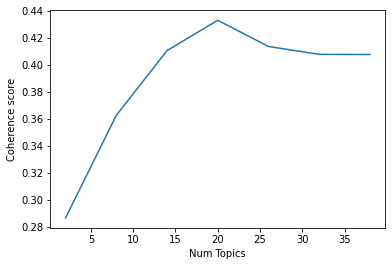

In [ ]:

# Show graph
limit=40 
start=2
step=6
x = range(start, limit, step)
plt.plot([i for i in x], coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

In [ ]:
#Looks like it starts to even out at num_topics = 30
print(coherence_values)
print([i for i in x])

[0.28674017379181505, 0.36263279177545477, 0.41057368731150456, 0.43307975563048123, 0.41365497601845846, 0.4078334901588835, 0.40770649944148385]
[2, 8, 14, 20, 26, 32, 38]


## Clustering: Word2Vec

### Training Embeddings

In [ ]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("/content/drive/MyDrive/Projects/AlbanianTwitter/bertshqip")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RobertaTokenizer'.


In [ ]:
from gensim.models import Word2Vec


In [ ]:
from gensim.models import Word2Vec
w2v_model = Word2Vec([i.split() for i in df.text],
                     min_count=600,
                     window=10,
                     size=250,
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers = 4,
                     seed = 42)

In [ ]:
#w2v_model.save("/content/drive/MyDrive/Projects/AlbanianTwitter/bertshqip/word2vec.model")
#w2v_model = Word2Vec.load("/content/drive/MyDrive/Projects/AlbanianTwitter/bertshqip/word2vec.model")

### Training Clusters

In [ ]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding
    https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/
    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(df.text, model=w2v_model)
len(vectorized_docs), len(vectorized_docs[0])

(178087, 250)

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        cluster_silhouette_values = sample_silhouette_values[km.labels_ == k]
        silhouette_values.append(
                (
                    k,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_



In [ ]:
clustering, cluster_labels = mbkmeans_clusters(
	X=vectorized_docs,
    k=num_topics,
    mb=500,
    print_silhouette_values=False,
)
df_clusters = pd.DataFrame({
    "text": df.text,
    "topic": cluster_labels
})

For n_clusters = 30
Silhouette coefficient: 0.06
Inertia:118768.17113420395


In [ ]:
# concatenate the string
tops = df_clusters.groupby(['topic'])['text'].transform(lambda x : ' '.join(x))
  
# drop duplicate data
tops2 = tops.drop_duplicates() 

In [ ]:
adocs_per_topic = df_clusters.groupby(['topic'], as_index = False).agg({'text': ' '.join})


import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=alb_stopwords).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
atf_idf, acount = c_tf_idf(adocs_per_topic.text.values, m=len(df.text.to_list()))

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=50):
    words = count.get_feature_names()
    labels = list(docs_per_topic.topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

atop_n_words = extract_top_n_words_per_topic(atf_idf, acount, adocs_per_topic, n=100)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print("Most representative terms per cluster (based on centroids):")
num_topics = 30
for i in range(num_topics):
  print("Topic " + str(i))
  print(atop_n_words[i])
  print("-----------------")

Most representative terms per cluster (based on centroids):
Topic 0
[('kosov', 0.05608461487492125), ('seks', 0.02284252377854719), ('shum', 0.02274681511978198), ('serbis', 0.022622370183693986), ('serb', 0.019826175155514766), ('shqiperis', 0.019235132702566396), ('mess', 0.01865304258686996), ('arsyej', 0.018606651020718238), ('sukses', 0.015823098406415805), ('sot', 0.014774658031100549), ('cfar', 0.014681049743413653), ('video', 0.014149935196116238), ('ndeshj', 0.013341896511014523), ('marreveshj', 0.011745463762928636), ('seps', 0.01140477505154644), ('ish', 0.011024125417139019), ('pare', 0.010507167808988966), ('bashk', 0.010403194780778524), ('shkak', 0.01002202314891731), ('foto', 0.00997962196167657), ('dash', 0.0098770321288065), ('shqiptar', 0.00966566399332258), ('shba', 0.00952057858458629), ('shikon', 0.009396384520683835), ('ndrysh', 0.009318897033774715), ('shqiper', 0.009237428340821622), ('berish', 0.008726625054362712), ('policis', 0.008660387890139107), ('kish', 

### Evaluation

In [ ]:
#Merge all to original df
wv_df = pd.merge(df, df_clusters, on=["text"])
wv_df2 = add_topics_hashtags(wv_df)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
#wv_df2.to_csv("/content/drive/MyDrive/Projects/AlbanianTwitter/wv_df2.csv")

In [ ]:
wv_df2_manual = add_topics_hashtags(wv_df)
wv_df2_manual2 = wv_df2_manual[wv_df2_manual.label != 1000]
#wv_df2_manual2.to_csv("/content/drive/MyDrive/Projects/AlbanianTwitter/wv_df2_manual.csv")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
w2v_eval = evaluation(w2v_model, wv_df2)
w2v_eval

{'hashtags_f1': 0.9147371389173604,
 'hashtags_precision': 0.9352963470059802,
 'hashtags_recall': 0.9239088538714432,
 'method': <gensim.models.word2vec.Word2Vec at 0x7f1611c00a10>,
 'percent_hashtags_correct': 0.4962}

## Clustering: BERT Embeddings

### Train Embeddings

Steps:
* Getting the data
* Building a tokenizer
* Creating an input pipeline
* Training the model
* Using kMeans on embeddings

BertShqip or XhaxhiBerti

In [ ]:
#Step 1: Store data in format for tokenizer. Create plaintext files with just the text from our dataset. We will split each sample using newline.
from tqdm.auto import tqdm

text_data = []
file_count = 0

for sample in tqdm(df['text']):
    sample = sample.replace('\n', '')
    text_data.append(sample)
    if len(text_data) == 1_000:
        # once we git the 10K mark, save to file
        with open(f'/content/drive/MyDrive/Projects/AlbanianTwitter/data/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        text_data = []
        file_count += 1
# after saving in 10K chunks, we will have ~2082 leftover samples, we save those now too
with open(f'/content/drive/MyDrive/Projects/AlbanianTwitter/data/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
    fp.write('\n'.join(text_data))

  0%|          | 0/178087 [00:00<?, ?it/s]

In [ ]:
#Step 2: Building a tokenizer
from pathlib import Path

paths = [str(x) for x in Path('/content/drive/MyDrive/Projects/AlbanianTwitter/data').glob("*.txt")]
         
paths[:7]

['/content/drive/MyDrive/Projects/AlbanianTwitter/data/text_0.txt',
 '/content/drive/MyDrive/Projects/AlbanianTwitter/data/text_4.txt',
 '/content/drive/MyDrive/Projects/AlbanianTwitter/data/text_2.txt',
 '/content/drive/MyDrive/Projects/AlbanianTwitter/data/text_3.txt',
 '/content/drive/MyDrive/Projects/AlbanianTwitter/data/text_1.txt',
 '/content/drive/MyDrive/Projects/AlbanianTwitter/data/text_5.txt',
 '/content/drive/MyDrive/Projects/AlbanianTwitter/data/text_6.txt']

In [ ]:
#Tokenizing by bytes.  So do not need to include tokens like [UNK] for unknown tokens. 
#!pip install tokenizers
from tokenizers import ByteLevelBPETokenizer

tokenizer = ByteLevelBPETokenizer()
tokenizer.train(files = paths, vocab_size = 30_522, #BERT size tokenizer. May want to increase later.
                min_frequency = 2,
                special_tokens = ['<s>', '<pad>', '</s>', '<unk>', '<mask>']
               ) 

In [ ]:
#Save to file. (TODO) See IG photo for writeup detail on "babai" and "baballaret"
import os
#os.mkdir("bertshqip")
tokenizer.save_model("/content/drive/MyDrive/Projects/AlbanianTwitter/bertshqip")

In [ ]:
#import tokenizer
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("/content/drive/MyDrive/Projects/AlbanianTwitter/bertshqip")
tokenizer("ckemi si je", max_length=10, padding = 'max_length')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RobertaTokenizer'.


{'input_ids': [0, 614, 4677, 352, 353, 2, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]}

In [ ]:
from sentence_transformers import SentenceTransformer
bertmodel = SentenceTransformer('bert-base-multilingual-uncased')
embeddings = bertmodel.encode(df.text, show_progress_bar=True)

In [ ]:
#np.save('/content/drive/MyDrive/Projects/AlbanianTwitter/bertshqip/embeddings.npy', embeddings)

In [ ]:
#Instead of embeddings cell:
from sentence_transformers import SentenceTransformer
bertmodel = SentenceTransformer('bert-base-multilingual-uncased')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/672M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Instead of embeddings cell: 
embeddings = np.load('/content/drive/MyDrive/Projects/AlbanianTwitter/bertshqip/embeddings.npy')

### Train Clusters

In [ ]:
bert_clustering, bert_cluster_labels = mbkmeans_clusters(
	X=embeddings,
    k=30,
    mb=500,
    print_silhouette_values=False,
)
df_bert_clusters = pd.DataFrame({
    "text": df.text,
    "topic": bert_cluster_labels
})

For n_clusters = 30
Silhouette coefficient: 0.02
Inertia:1625384.25


In [ ]:
docs_per_topic = df_bert_clusters.groupby(['topic'], as_index = False).agg({'text': ' '.join})


import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.text.values, m=len(df.text.to_list()))

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=50):
    words = count.get_feature_names()
    labels = list(docs_per_topic.topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=50)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print("Most representative terms per cluster (based on centroids):")
num_topics = 30
for i in range(num_topics):
  print("Topic " + str(i))
  print(top_n_words[i])
  print("-----------------")

Most representative terms per cluster (based on centroids):
Topic 0
[('kosov', 0.037957797856777754), ('rt', 0.03150676664628096), ('ne', 0.01729338148216646), ('video', 0.017231393682283297), ('kosovo', 0.01654461621029758), ('nga', 0.015450553487155025), ('sot', 0.01534548069796965), ('foto', 0.015012344832069957), ('gazet', 0.014918965537180423), ('shqiper', 0.01423682907885649), ('shtet', 0.014187756673956345), ('shqiptar', 0.014081101343639773), ('se', 0.012930082466910117), ('shqiperi', 0.011799732264886453), ('serb', 0.011710711133632193), ('tiran', 0.011501210349738287), ('ky', 0.011456353435304241), ('histor', 0.011273206009128697), ('albani', 0.011000231642827372), ('mes', 0.010460174611345609), ('si', 0.010402570528119555), ('kjo', 0.009983516349944307), ('nje', 0.009686077530281584), ('post', 0.00960946955780002), ('shqipt', 0.009607713198152151), ('kush', 0.009517575079363412), ('vizit', 0.009375112328108013), ('falas', 0.009329731805324074), ('politik', 0.0093023572267680

### Evaluation

In [ ]:
#Merge all to original df
bert_df = pd.merge(df, df_bert_clusters, on=["text"])
bert_df2 = add_topics_hashtags(bert_df)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
#bert_df2.to_csv("/content/drive/MyDrive/Projects/AlbanianTwitter/bert_df2.csv")

In [ ]:
bert_df2_manual = add_topics_hashtags(bert_df)
bert_df2_manual2 = bert_df2_manual[bert_df2_manual.label != 1000]
#bert_df2_manual2.to_csv("/content/drive/MyDrive/Projects/AlbanianTwitter/bert_df2_manual.csv")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
bert_eval = evaluation(bertmodel, bert_df2, bert=True)
bert_eval

0
1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'hashtags_f1': 0.8840712628369408,
 'hashtags_precision': 0.9028000960929985,
 'hashtags_recall': 0.9035384180080482,
 'method': SentenceTransformer(
   (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
   (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
 ),
 'percent_hashtags_correct': 0.4293}

## Performance Summary

In [ ]:
#Join results to single dataframe
a=pd.DataFrame.from_dict(lda_eval, orient = 'index')
b=pd.DataFrame.from_dict(w2v_eval, orient = 'index')
bert_eval['method'] = str(bert_eval['method'][0]) + " -- " + str(bert_eval['method'][1])

In [ ]:
c=pd.DataFrame.from_dict(bert_eval, orient = 'index')
m = a.merge(b, on = a.index).set_index('key_0')
m2 = m.merge(c, on = m.index)

In [ ]:
#Rename and format final table
comparisons = m2.rename(columns = {"key_0": "key", "0_x": "LDA", "0_y": "Word2Vec + KMeans", 0: "Multilingual BERT + KMeans"}).set_index("key")
comparisons

In [ ]:
#comparisons.to_csv("/content/drive/MyDrive/Projects/AlbanianTwitter/bertshqip/final_numbers.csv")

In [ ]:
import pandas as pd
import numpy as np

comps = pd.read_csv("/content/drive/MyDrive/Projects/AlbanianTwitter/bertshqip/final_numbers.csv")
comps

In [ ]:
comps2 = comps.set_index('key').T.drop(columns = ['method'])

In [ ]:
comps3 = comps2.rename(columns = {'key': '_', 'percent_hashtags_correct': "Accuracy", "hashtags_precision": "Precision", 
                         "hashtags_recall": "Recall", "hashtags_f1": "F1 Score"})

In [ ]:
comps3

key,Accuracy,Precision,Recall,F1 Score
LDA,0.1903,0.5654604666891743,0.5093843843843844,0.47884382983442797
Word2Vec + KMeans,0.4962,0.9352963470059802,0.9239088538714432,0.9147371389173604
Multilingual BERT + KMeans,0.4293,0.9028000960929985,0.9035384180080482,0.8840712628369408


## Appendix

In [ ]:
#Hashtag value counts
all_hashtags = pd.Series([item for sublist in df1.hashtags for item in sublist])
print("Total number of hashtags used across tweets: " + str(len(all_hashtags)))
print("Counts of top 15 hashtags: ")
all_hashtags.value_counts().head(15)


Total number of hashtags used across tweets: 169132
Counts of top 15 hashtags: 


0                150778
shqiperi         406   
kosova           373   
shqip            248   
kosovo           223   
kosove           193   
albania          136   
shkodres         130   
gjermani         115   
perkthim         108   
tring            107   
lajm             102   
tringbuzeqesh    99    
topstory         95    
businessmag      94    
dtype: int64

In [ ]:
#Topic/Hashtag pivot table

flattened_df = df1[['text', 'hashtags', 'topic']].explode("hashtags")
hashtag_topic_pivot = pd.pivot_table(flattened_df, values='text', index=['hashtags'],
                    columns=['topic'], aggfunc='count', fill_value=0).sort_values(by = [1], ascending = False)

In [ ]:
hashtag_topic_pivot

topic,1,2,3,4,5,6,7,8,9,10,11,12,13,14
hashtags,,,,,,,,,,,,,,
0,19007,6624,8126,6758,17937,8878,14619,11069,7987,9077,9866,8200,9048,13582
perkthim,47,0,1,2,0,9,0,0,7,1,2,4,3,32
bibla,36,0,2,0,0,4,0,0,0,0,0,0,0,14
shqip,21,10,16,8,62,10,20,17,12,21,23,6,14,8
muxhahedinetmek,18,0,0,0,0,0,0,0,0,0,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
helikopteri,0,0,1,0,0,0,0,0,0,0,0,0,0,0
hekuri,0,0,0,0,0,0,0,0,1,0,0,0,0,0
heisback,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
#Top hashtags per topic

for topic in range(1,num_topics):
    d = hashtag_topic_pivot.sort_values(by = [topic], ascending = False).head(15)
    plt.figure()
    ax1 = sns.barplot(x = d[1:][topic], y = d[1:].index, palette = "PuRd");
    ax1.set_title("Top Hashtags for Topic " + str(topic));

In [ ]:
#Count of first top hashtag per topic / total txts

for i in range(1, num_topics):
    d = hashtag_topic_pivot.sort_values(by = [i], ascending = False)

    print("Topic " + str(i) + ": Proportion of all tweets with hashtag " + str(d[i].index[1]))
    prop = d[i].iloc[1]/d[i].sum()
    print(round(prop, 4))

Topic 1: Proportion of all tweets with hashtag perkthim
0.0023
Topic 2: Proportion of all tweets with hashtag adikrastes
0.008
Topic 3: Proportion of all tweets with hashtag kosova
0.0025
Topic 4: Proportion of all tweets with hashtag shqiperi
0.033
Topic 5: Proportion of all tweets with hashtag kosova
0.0036
Topic 6: Proportion of all tweets with hashtag valbones
0.0023
Topic 7: Proportion of all tweets with hashtag topstory
0.0035
Topic 8: Proportion of all tweets with hashtag thearchitect
0.0038
Topic 9: Proportion of all tweets with hashtag kosova
0.0049
Topic 10: Proportion of all tweets with hashtag diasporashqiptare
0.0022
Topic 11: Proportion of all tweets with hashtag shkodres
0.0113
Topic 12: Proportion of all tweets with hashtag kosova
0.0077
Topic 13: Proportion of all tweets with hashtag fifaworldcup2018
0.0051
Topic 14: Proportion of all tweets with hashtag thahoxha
0.0034


In [ ]:
#Count of first top hashtag per topic / count of txts with any hashtag

for i in range(1, num_topics):
    d = hashtag_topic_pivot.sort_values(by = [i], ascending = False)[1:]

    print("Topic " + str(i) + ": Proportion of all tweets that have at least 1 hashtag with hashtag " + str(d[i].index[0]))
    prop = d[i].iloc[0]/d[i].sum()
    print(round(prop, 4))

Topic 1: Proportion of all tweets that have at least 1 hashtag with hashtag perkthim
0.0288
Topic 2: Proportion of all tweets that have at least 1 hashtag with hashtag adikrastes
0.0479
Topic 3: Proportion of all tweets that have at least 1 hashtag with hashtag kosova
0.0313
Topic 4: Proportion of all tweets that have at least 1 hashtag with hashtag shqiperi
0.2181
Topic 5: Proportion of all tweets that have at least 1 hashtag with hashtag kosova
0.0465
Topic 6: Proportion of all tweets that have at least 1 hashtag with hashtag valbones
0.016
Topic 7: Proportion of all tweets that have at least 1 hashtag with hashtag topstory
0.0387
Topic 8: Proportion of all tweets that have at least 1 hashtag with hashtag thearchitect
0.0514
Topic 9: Proportion of all tweets that have at least 1 hashtag with hashtag kosova
0.0323
Topic 10: Proportion of all tweets that have at least 1 hashtag with hashtag diasporashqiptare
0.0198
Topic 11: Proportion of all tweets that have at least 1 hashtag with ha

In [ ]:
#Monthyear value counts
df1['monthyear'] = df1.created_at.dt.to_period('M')
print("Total month rage across tweets: " + str((df1['monthyear'].nunique())))
print("Counts of tweets by month: ")
df1.monthyear.value_counts()

Total month rage across tweets: 37
Counts of tweets by month: 


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  Return the month names of the DateTimeIndex with specified locale.


2018-11    7778
2018-12    7404
2018-10    6523
2018-06    5936
2018-09    5916
2018-05    5692
2018-08    5439
2018-03    5423
2018-04    5165
2018-07    5090
2017-11    4781
2017-06    4593
2017-03    4458
2017-02    4379
2017-05    4204
2017-01    4145
2017-07    4079
2016-12    3995
2018-01    3979
2016-11    3932
2017-04    3853
2018-02    3769
2016-03    3703
2017-10    3663
2016-06    3581
2016-04    3569
2016-05    3524
2016-09    3522
2017-09    3521
2017-12    3470
2016-07    3396
2016-10    3296
2016-08    3275
2016-01    3130
2017-08    3123
2016-02    3061
2015-12    2524
Freq: M, Name: monthyear, dtype: int64

In [ ]:
#Topic/Monthyear pivot table
month_topic_pivot = pd.pivot_table(df1, values='text', index=['monthyear'],
                    columns=['topic'], aggfunc='count', fill_value=0).sort_values(by = ['monthyear'], ascending = True)
month_topic_pivot

topic,1,2,3,4,5,6,7,8,9,10,11,12,13,14
monthyear,,,,,,,,,,,,,,
2015-12,424,112,150,91,255,143,209,281,155,132,102,109,117,244
2016-01,511,122,199,130,379,169,231,297,167,180,174,114,154,303
2016-02,532,143,187,104,319,204,247,275,159,123,160,155,133,320
2016-03,502,172,207,123,456,211,298,377,198,200,145,200,184,430
2016-04,481,187,206,117,443,207,264,361,222,180,177,197,177,350
2016-05,479,194,205,132,423,231,283,427,197,172,175,133,143,330
2016-06,504,167,190,180,393,264,265,435,187,150,170,149,146,381
2016-07,473,134,184,128,426,144,314,428,180,146,194,204,155,286
2016-08,465,184,194,146,415,197,241,419,156,151,140,174,140,253


In [ ]:
#Top monthyears per topic

for topic in range(1,num_topics):
    plt.figure(figsize = (15,5))
    ax2 = sns.lineplot(y = month_topic_pivot[topic], x = month_topic_pivot[topic].index.astype(str), palette = "PuRd");
    ax2.set_title("Top Months for Topic " + str(topic));
    plt.xticks(rotation=60);

In [ ]:
#Count of first top monthyear per topic / total txts

for i in range(1, num_topics):
    d = month_topic_pivot.sort_values(by = [i], ascending = False)

    print("Topic " + str(i) + ": Proportion of all tweets that are in  " + str(d[i].index[0]))
    prop = d[i].iloc[0]/d[i].sum()
    print(round(prop, 4))
    
#Not very informing because tweets automatically grow.

Topic 1: Proportion of all tweets that are in  2018-10
0.045
Topic 2: Proportion of all tweets that are in  2018-12
0.0734
Topic 3: Proportion of all tweets that are in  2018-11
0.0559
Topic 4: Proportion of all tweets that are in  2018-11
0.0927
Topic 5: Proportion of all tweets that are in  2018-10
0.0369
Topic 6: Proportion of all tweets that are in  2018-05
0.0471
Topic 7: Proportion of all tweets that are in  2017-06
0.051
Topic 8: Proportion of all tweets that are in  2016-06
0.0376
Topic 9: Proportion of all tweets that are in  2018-12
0.0524
Topic 10: Proportion of all tweets that are in  2018-12
0.0571
Topic 11: Proportion of all tweets that are in  2018-11
0.08
Topic 12: Proportion of all tweets that are in  2018-11
0.0568
Topic 13: Proportion of all tweets that are in  2018-11
0.0459
Topic 14: Proportion of all tweets that are in  2018-12
0.059


### Thank you!